In [1]:
import sys
import os

current_directory = os.getcwd()        
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from spektral.layers import GCNConv

from postprocess.threshold import flood_threshold, drought_threshold
from preprocess.BaselinePrerocess import baseline_process, baseline_process_for_gate_predictor
from preprocess.GraphTransformerPrerocess import graph_water_transformer_cov_process_for_gate_predictor
from preprocess.graph import graph_topology_5

import pygad
import time

2023-08-05 11:24:11.180573: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-05 11:24:12.776568: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

### Preprocess

In [4]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9
sigma2 = 0.1
epsilon = 0.5

In [5]:
train_cov, val_cov, test_cov, \
train_tws_reshape, val_tws_reshape, test_tws_reshape, \
train_gate_pump_y, val_gate_pump_y, test_gate_pump_y, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler, gate_scalar = graph_water_transformer_cov_process_for_gate_predictor(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')
train_tws/val_tws/test_tws: (77069, 5, 72) (9634, 5, 72) (19268, 5, 72) 
 train_cov/val_cov/test_cov: (77069, 96, 12) (9634, 96, 12) (19268, 96, 12) 
 train_ws_y/val_ws_y/test_ws_y: (77069, 96) (9634, 96) (19268, 96) 
  train_gate_pump_y/val_gate_pump_y/test_gate_pump_y: (77069, 24, 7) (9634, 24, 7) (19268, 24, 7)


In [6]:
train_adj_mat, val_adj_mat, test_adj_mat = graph_topology_5(n_hours, K, sigma2, epsilon, len(train_ws_y), len(val_ws_y), len(test_ws_y))

node_indices: [0 0 0 0 1 1 2 2 3 3 4 4] 
neighbor_indices: [1 2 3 4 0 2 0 1 0 4 0 3]
number of nodes: 5, number of edges: 12


### Select event

In [7]:
start_idx = 10000
end_idx = 10200
duration = end_idx - start_idx

In [8]:
ws1 = test_ws_y[start_idx:end_idx, :]
ws1 = ws_scaler.inverse_transform(ws1)
ws1.shape

(200, 96)

In [9]:
# plt.plot(ws1[:, 0], label='S1')
# plt.xlabel('Time', fontsize=18)
# plt.ylabel('S1 Water Stage', fontsize=18)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.legend(fontsize=14)
# plt.show()

### Get optimizable and not optimizable variables

In [10]:
# X = test_X_mask[start_idx:end_idx, :, :]
# X_1d = np.reshape(X, -1)

# print(X.shape)
# print(X_1d.shape)

In [11]:
# optimizable
gate_state = test_cov[start_idx:end_idx, :, 2:9]
gate_state_1d = np.reshape(gate_state, -1)

print(gate_state.shape)
print(gate_state_1d.shape)

(200, 96, 7)
(134400,)


In [12]:
# not optimizable
not_gate1 = test_cov[start_idx:end_idx, :, 0:2]

print(not_gate1.shape)

(200, 96, 2)


In [13]:
# not optimizable
not_gate2 = test_cov[start_idx:end_idx, :, 9:]

print(not_gate2.shape)

(200, 96, 3)


### GA

In [14]:
saved_model = load_model('../saved_models/WaLeF_gtn_p.h5', custom_objects={'GCNConv': GCNConv})

2023-08-05 11:24:22.279452: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10402 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:09:00.0, compute capability: 6.1


In [15]:
def fitness_func(ga_instance, solution, solution_idx):
    # ================ gate penalty ================
    solution = np.reshape(solution, (duration, 96*7))
    gate_max = 1
    gate_min = 0
    
    gate_penalty_sum = 0
    for i in range(duration):
        for j in range(96*7):
            if (solution[i, j] > gate_max):
                penalty_gate = np.abs(solution[i, j] - gate_max)**2
            elif (solution[i, j] < gate_min):
                penalty_gate = np.abs(solution[i, j] - gate_min)**2
            else:
                penalty_gate = 0
            gate_penalty_sum += penalty_gate

    # ================ get input numpy of gate ================
    solution = np.reshape(solution, (duration, 96, 7))
    input_np = np.zeros(((duration, 96, 12)))
    input_np[:, :, 0:2] = not_gate1
    input_np[:, :, 2:9] = solution
    input_np[:, :, 9:] = not_gate2
    
    # ================ predict ws ================
    yhat = saved_model.predict([input_np, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
    #yhat = saved_model.predict(input_np, verbose=0)
    
    
    # ================ ws penalty ================
    y_max = 0.62
    y_min = 0.2
    
    ws_penalty_sum = 0
    for i in range (duration):
        for j in range (96):
            if (yhat[i, j] > y_max):
                penalty_ws = np.abs(yhat[i, j] - y_max) + 20*np.abs(yhat[i, j] - y_max)**2
            elif (yhat[i, j] < y_min):
                penalty_ws = np.abs(y_min - yhat[i, j])
                
            else:
                penalty_ws = 0
            
            ws_penalty_sum += penalty_ws
    
    # ================ gate penalty + ws penalty ================
    penalty_gate_ws_sum = 0.2*gate_penalty_sum + 2.0*ws_penalty_sum
    
    if penalty_gate_ws_sum == 0:
        fitness = 9999999999999
    else:
        fitness = 1.0 / penalty_gate_ws_sum
    return fitness

In [16]:
fitness_function = fitness_func

num_generations = 200
num_parents_mating = 8

sol_per_pop = 64
num_genes = len(gate_state_1d)

init_range_low = 0
init_range_high = 1

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 5

In [17]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_space = {'low': 0, 'high': 1})

In [18]:
start_time = time.perf_counter()
ga_instance.run()
cpu_time = time.perf_counter() - start_time
print(f"CPU time: {cpu_time} seconds")

2023-08-05 11:24:25.242821: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 4ms/step
CPU time: 3787.315973375924 seconds


In [19]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

7/7 [==============================] - 0s 3ms/step
Parameters of the best solution : [0.14812703 0.01006778 0.46425532 ... 0.75980784 0.93576736 0.32616693]
Fitness value of the best solution = 0.002853950836935572


### Post-processing

In [20]:
best_gate = np.reshape(solution, (duration, 96, 7))

best_input = np.zeros(((duration, 96, 12)))
best_input[:, :, 0:2] = not_gate1
best_input[:, :, 2:9] = best_gate
best_input[:, :, 9:] = not_gate2

best_perf = saved_model.predict([best_input, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
best_perf = ws_scaler.inverse_transform(best_perf)

7/7 [==============================] - 0s 3ms/step


In [21]:
count = 0

for i in range (duration):
    for j in range (96):
        if best_perf[i, j] > 3.5:
            count += 1

print(count)

0


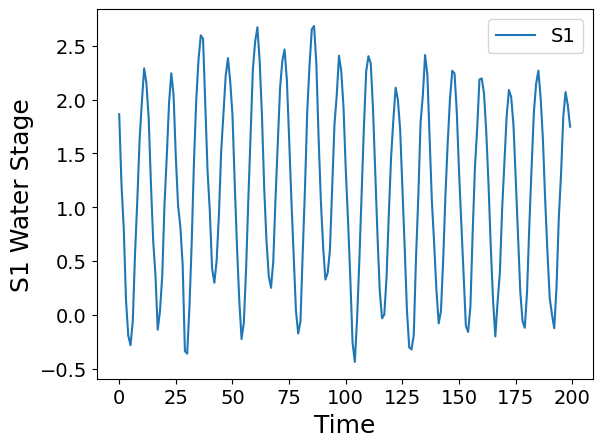

In [22]:
plt.plot(best_perf[:, 0], label='S1')
plt.xlabel('Time', fontsize=18)
plt.ylabel('S1 Water Stage', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [23]:
Optimal_gate = pd.DataFrame(best_gate.reshape(duration, -1) )
Optimal_gate.to_csv("GA_results/best_gate_event_low11.csv", index=False)
Optimal_gate

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,668,669,670,671
0,0.148127,0.010068,0.464255,0.125972,0.774798,0.502505,0.257141,0.295882,0.087158,0.872550,...,0.984452,0.629604,0.507191,0.512906,0.825267,0.905707,0.807858,0.953614,0.143642,0.350787
1,0.859708,0.984297,0.190718,0.101809,0.908619,0.141397,0.509158,0.855461,0.302165,0.561933,...,0.788255,0.773671,0.835048,0.553561,0.315703,0.434884,0.073818,0.160286,0.393393,0.629333
2,0.840544,0.768645,0.508656,0.822013,0.731717,0.049052,0.467861,0.745054,0.420025,0.053841,...,0.208880,0.738410,0.008402,0.900559,0.032824,0.033242,0.540731,0.832121,0.687434,0.607307
3,0.153141,0.969875,0.056106,0.613347,0.903251,0.016304,0.371130,0.515638,0.170009,0.675858,...,0.884477,0.490088,0.043501,0.001518,0.133167,0.012697,0.351800,0.613593,0.688183,0.300826
4,0.057987,0.617449,0.918349,0.648909,0.802991,0.103365,0.666803,0.463367,0.300120,0.453764,...,0.862538,0.381259,0.784223,0.753391,0.686793,0.006549,0.558100,0.836305,0.147852,0.422315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.656777,0.402852,0.918034,0.883079,0.663163,0.238143,0.407051,0.153791,0.283842,0.098991,...,0.140211,0.547787,0.731560,0.435086,0.552784,0.028047,0.255864,0.455537,0.705595,0.503655
196,0.065040,0.165354,0.917165,0.409236,0.825613,0.762450,0.161803,0.238328,0.084579,0.818897,...,0.976188,0.813886,0.081576,0.885300,0.521774,0.022044,0.951304,0.841578,0.945550,0.282734
197,0.861754,0.683840,0.230873,0.646878,0.859383,0.776551,0.373778,0.035229,0.316584,0.749723,...,0.216165,0.921496,0.901617,0.527120,0.660642,0.784561,0.146810,0.327661,0.982203,0.088812
198,0.725954,0.164526,0.331889,0.255542,0.121489,0.967642,0.699910,0.623283,0.158596,0.688951,...,0.872188,0.499083,0.222075,0.568022,0.679292,0.362469,0.659111,0.994385,0.568899,0.937998


In [24]:
Optimal_case = pd.DataFrame(best_perf)
Optimal_case.to_csv("GA_results/best_performance_event_low11.csv", index=False)
Optimal_case

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,1.863970,2.224324,2.041675,1.956373,1.377912,1.433002,1.468231,1.450105,0.734787,0.618387,...,1.450242,1.499809,1.865836,1.912624,1.882148,1.949035,2.133294,2.194760,2.181218,2.277072
1,1.214788,1.514483,1.374433,1.269004,0.789466,0.840010,0.963657,0.863792,0.292290,0.490054,...,1.707346,1.826334,2.183637,2.217386,2.144568,2.263537,1.867052,2.100859,1.921074,1.969852
2,0.807015,0.830029,0.982513,0.916398,0.196528,-0.017278,0.316465,0.229782,-0.239911,-0.070645,...,2.114367,2.237948,1.911300,2.062976,1.946101,2.068183,1.546776,1.706814,1.624296,1.687799
3,0.138361,0.005948,0.258487,0.166535,-0.179552,-0.222418,-0.094762,-0.167128,-0.320701,-0.377817,...,2.067411,2.159138,1.539151,1.571553,1.732344,1.788119,0.876889,0.761223,1.069975,1.081625
4,-0.193019,-0.345644,-0.046459,-0.182826,-0.315621,-0.246254,-0.246403,-0.364991,-0.068296,0.018231,...,1.582548,1.655325,0.960033,1.190537,1.122668,1.133636,0.804500,1.071702,0.975519,0.933197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1.309645,1.369194,1.286808,1.304009,1.930661,1.843216,1.836912,1.997747,2.034116,2.050100,...,0.218937,0.130493,0.227559,0.558453,0.348352,0.343708,0.560472,0.676320,0.654050,0.635231
196,1.843804,1.713742,1.870941,1.959404,2.089722,2.311796,1.973518,2.138364,2.137722,2.007443,...,0.232745,0.239984,0.573486,0.485652,0.584276,0.699853,1.074145,1.234875,1.022564,1.168555
197,2.069743,2.174033,2.147095,2.193205,2.065089,1.969000,2.049857,2.105605,1.727974,1.884713,...,0.601443,0.556077,1.043397,1.216841,1.024947,1.135316,1.440910,1.485188,1.390774,1.545782
198,1.943893,1.803855,1.954363,1.968631,1.743062,1.735825,1.706960,1.819431,1.116128,1.071818,...,1.016507,1.127101,1.430207,1.322500,1.398142,1.531399,1.907304,1.930915,1.903723,2.037257


In [25]:
upper_threshold = 3.5
lower_threshold = 0

Optimal_case_reshape = Optimal_case.to_numpy().reshape((-1, 24, 4))

flood_threshold(Optimal_case_reshape, upper_threshold)
drought_threshold(Optimal_case_reshape, lower_threshold)


time steps: 0, areas: 0
time steps: 928, areas: 120.16274572219118


In [26]:
true_ws = saved_model.predict([test_cov[start_idx:end_idx], test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
true_ws = ws_scaler.inverse_transform(true_ws)

true_ws = true_ws.reshape((-1, 24, 4))
flood_threshold(true_ws, upper_threshold)
drought_threshold(true_ws, lower_threshold)

7/7 [==============================] - 0s 3ms/step
time steps: 0, areas: 0
time steps: 2648, areas: 497.09403592464514
